## Step 1) Lower your expectations
## Step 2) Repeat Step 1

As of 10/17, this notebook takes a user's address and dumps out names, pictures, and effectiveness & bipartisanship graphs. The graphs will display data back as far as the 113th congress if any member has a history that far back.

Concerns:
- The method used right now to turn Google Civic API results into the member IDs required for ProPublica feels like a hot mess.
- There is no error handling whatsoever
- The display is ugly
- Still don't have data on top 5-ish topics for bill activity
- Probably lots of other stuff, but I'm fried

In [26]:
#these magic statements can be removed once development is complete
%reload_ext autoreload
%autoreload 2

#custom-built module!
import api_utils

#pre-fab modules - basically the mobile homes of import statements
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image, display
%matplotlib inline

In [2]:
# This executable .py performs batch processing on bulk legislative data
# Only run this command if you want to re-create (or update) effectiveness.csv

# It takes a couple minutes to run if you don't comment out the bulk_update() function call
# within that file (line 269)

#!python bulk_processing.py

In [3]:
def show_metrics(df, member_id):
    '''helper function to produce hideous visualizations
    come to think of it, that's not very helpful at all!'''
    
    # Determine applicable chamber and congress(es) based on member id
    congresses = sorted(df[df.id == member_id].congress.unique())
    chamber = sorted(df[df.id == member_id].chamber.unique())[0]
    
    # Loop through every applicable congress for the given member_id
    for congress in congresses:
        # Filter the dataframe to only the data we want to plot
        temp_df = df[(df.congress == congress) & (df.chamber == chamber) & (df.bi_sponsor_count != 0)]
        #member_index = np.where(temp_df.id == member_id)[0][0]
        colors = []
        for i in range(len(temp_df.color)):
            if list(temp_df.id)[i] == member_id:
                colors.append('green')
            else:
                colors.append(list(temp_df.color)[i])
        
        # Build the plots
        plt.figure(figsize=(10, 10))
        
        plt.subplot(221)
        plt.scatter(temp_df.sponsor_rank, temp_df.cosponsor_rank, color=colors, s=temp_df['size'])
        plt.xlabel('sponsorship rank')
        plt.ylabel('cosponsorship rank')
        ax = plt.gca()
        ax.set_xlim([0,max(temp_df.sponsor_rank)+2])
        ax.invert_xaxis()
        ax.set_ylim([0,max(temp_df.cosponsor_rank)+2])
        ax.invert_yaxis()
        plt.title('%s %s Effectiveness Rankings' %(congress, chamber))

        plt.subplot(222)
        red = temp_df[temp_df.color == 'red']
        blue = temp_df[temp_df.color == 'blue']
        plt.hist(red.bi_pct, color='Red', alpha=0.5)
        plt.hist(blue.bi_pct, color='Blue', alpha=0.5)
        plt.title('Bill Sponsor Bipartisanship')
        plt.xlabel('portion of bills sponsored w/bipartisan support')
        plt.ylabel('count')
        pct = list(temp_df[temp_df.id == member_id]['bi_pct'])[0]
        plt.axvline(pct, color='green', linestyle='dashed', linewidth=3)
        
        plt.show()


What is your address?
e.g.: 1313 Disneyland Dr, Anaheim, CA 92802
Please type your address here: 1313 Disneyland Dr, Anaheim, CA 92802

chamber: senate
name: Kamala D. Harris


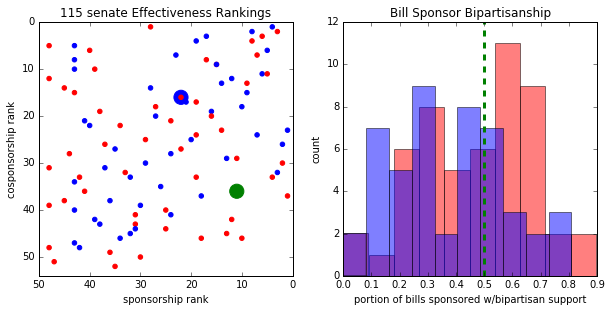



chamber: senate
name: Dianne Feinstein


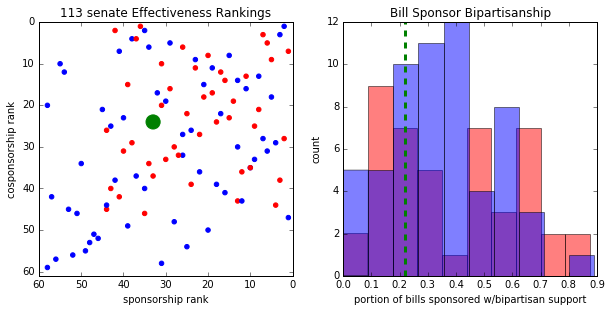

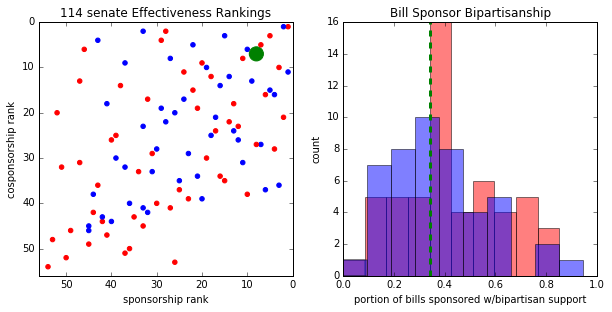

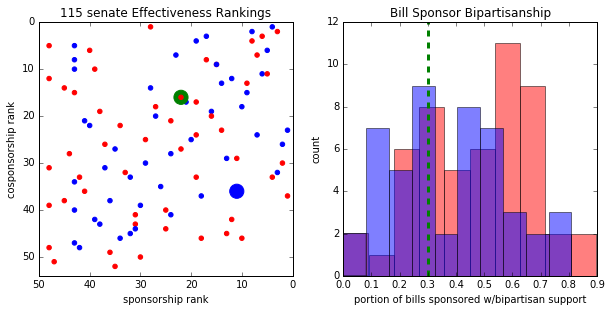



chamber: house
name: J. Luis Correa


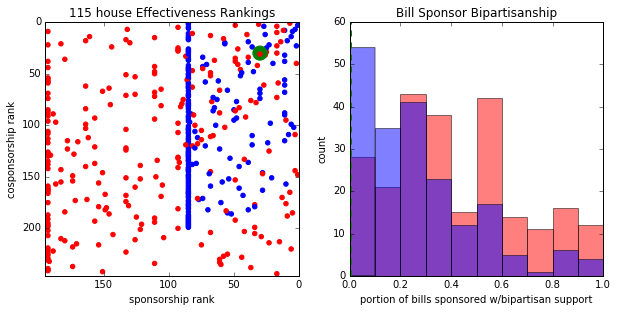

In [4]:
# Read in bulk data
df = pd.read_csv('./effectiveness.csv')

# Collect user's address
print 'What is your address?'
print 'e.g.: 1313 Disneyland Dr, Anaheim, CA 92802'
address = raw_input('Please type your address here: ')
print ''

# Instantiate the class required to translate the address
g = api_utils.Google()
my_reps = g.ids_from_address(address)

# Update the size attributes for "my" reps
all_ids = []
for chamber in my_reps:
    for member_id in my_reps[chamber]:
        all_ids.append(member_id)
for m_id in all_ids:
    if m_id in list(df.id):
        row_index = df.id == m_id
        df.loc[row_index,'size'] = 200

# Display representatives and collect IDs in single list
#all_ids = []
for chamber in my_reps:
    for member_id in my_reps[chamber]:
        #all_ids.append(member_id)
        print 'chamber: %s' %chamber
        print 'name: %s' %my_reps[chamber][member_id]['name']
        display(Image(url=my_reps[chamber][member_id]['img_url'], height=165, width=135))
        print ''
        show_metrics(df, member_id)
        print ''
        print ''

In [16]:
pp = api_utils.ProPublica()

for i in all_ids:
    member = pp.get_member(i)
    print member['first_name'], member['last_name'],
    print 'fec ID:', member['roles'][0]['fec_candidate_id']

Kamala Harris fec ID: S6CA00584
Dianne Feinstein fec ID: S0CA00199
J. Correa fec ID: H6CA46116


In [34]:
pp.get_member_fec('S0CA00199', '2012')

{u'base_uri': u'https://api.propublica.org/campaign-finance/v1/2012/',
 u'copyright': u'Copyright (c) 2017 ProPublica Inc. All Rights Reserved.',
 u'cycle': 2012,
 u'results': [{u'begin_cash': 3853697.0,
   u'candidate_loans': 5000000.0,
   u'committee': u'/committees/C00539890.json',
   u'coordinated_expenditures': 0.0,
   u'date_coverage_from': u'2011-01-01',
   u'date_coverage_to': u'2012-11-26',
   u'debts_owed': 0.0,
   u'district': u'/races/CA/senate.json',
   u'end_cash': 947793.0,
   u'fec_uri': u'http://docquery.fec.gov/cgi-bin/fecimg/?S0CA00199',
   u'id': u'S0CA00199',
   u'independent_expenditures': 8963.13,
   u'mailing_address': u'1212 S VICTORY BLVD',
   u'mailing_city': u'BURBANK',
   u'mailing_state': u'CA',
   u'mailing_zip': u'91502',
   u'name': u'FEINSTEIN, DIANNE',
   u'other_cycles': [2018, 2006, 2000, 1998, 1996, 1994, 1992],
   u'party': u'DEM',
   u'state': u'/races/CA.json',
   u'status': u'I',
   u'total_contributions': 7248485.07,
   u'total_disbursements':